<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/1_2_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Verbinden mit der Google Drive und Import der benötigten Module:

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import io, os, sys, setuptools, tokenize

In [3]:
!pip install pvlib

In [4]:
## import modules

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pvlib

from datetime import datetime
from datetime import timedelta
from prophet import Prophet
from math import sqrt

from scipy.fft import fft

In [5]:
# Größe der Plots festlegen
matplotlib.rcParams['figure.figsize'] = (13, 8)

In [6]:
latitude = 50.2
longitude = 7.8

seconds_in_day = 24*60*60
seconds_in_year = (365.2425)*seconds_in_day

tz, altitude, name = 'Europe/Berlin', 70, 'SanktAugustin'
tus = pvlib.location.Location(latitude, longitude, tz, altitude, name)

In [7]:
# Pfad zur CSV-Datei auf Google Drive
name_Messwerte = 'UVI_Messdaten.csv'
name_Vorhersage = 'Vorhersage.csv'
name_Solar_Messwerte = 'Solys_Messdaten.csv'
drive_path = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'
output_plot_path = '/content/drive/My Drive/Colab_Notebooks/plot_daily_UVI/'

In [8]:
# Import der Daten für die EDA
df_UVI = pd.read_csv(drive_path + name_Messwerte)
df_Solys = pd.read_csv(drive_path + name_Solar_Messwerte)
df_CAMS = pd.read_csv(drive_path + name_Vorhersage)

# Messzeitpunkt in Datetime umwandeln
df_UVI.set_index('Datetime', inplace=True)
df_Solys.set_index('Datetime', inplace=True)
df_CAMS.set_index('Datetime', inplace=True)

# Index in Datetime umwandeln
df_UVI.index = pd.to_datetime(df_UVI.index)
df_Solys.index = pd.to_datetime(df_Solys.index)
df_CAMS.index = pd.to_datetime(df_CAMS.index)

# NaN Einträge durch 0 ersetzen
df_UVI['UVI'] = df_UVI['UVI'].fillna(0)
df_UVI['erythem'] = df_UVI['erythem'].fillna(0)
df_Solys.dropna(inplace = True)

In [9]:
# Die Glo Spalte in den Solys-Daten in ghi umbenennen
df_rad = []
df_rad = df_Solys['Glo'].copy()
df_rad = pd.DataFrame({'ghi': df_rad})

In [10]:
df_rad.replace(0, np.nan, inplace=True)

# Entfernen aller Zeilen mit NaN-Werten
df_rad.dropna(inplace=True)

In [11]:
# Gruppieren des Dataframes nach Stunde - nur die ersten 1000 Datenpunkte
stundliche_gruppe = df_rad.groupby([df_rad.index.date, df_rad.index.hour])

In [12]:
# Stündlicher Durchschitt ohne Nullen
df_UVI_hourly = df_UVI[df_UVI['UVI'] != 0][['UVI','erythem', 'SZA']].resample('H').mean()

In [13]:
# Stündlicher Durchschitt mit Nullen
df_UVI_hourly_withZero = df_UVI[['UVI','erythem', 'SZA']].resample('H').mean()

In [14]:
# Klasse für den Klassifokator

def sigma_skartveit_GHI(rad_df):
    # Index nach Skarveit
    # berechnen des Variabiltätsindex sigma_skarveit_GHI mit Hilfe der Globalstrahlung
        """
        Eq. (3.1)
        paper uses DNI values. Here GHI
        can reach values above 1
        Skartveit A., J.A. Olseth, M.E. Tuft, 1998: An hourly
        diffuse fraction model with correction for variability
        and surface albedo. – Sol. Energy 63, 173–183, DOI:
        10.1016/S0038-092X(98)00067-X.

        Returns
        -------
        sigma_skartveit

        """
        tus = pvlib.location.Location(latitude, longitude, tz, altitude, name)
        cs = tus.get_clearsky(rad_df.index)

        # kc = Clear-Sky-Index | kc_t_m1 = Clear-Sky-Index of previus hour | kc_t_p1 = Clear-Sky-Index following hour
        kc = []
        kc_t_m1 = []
        kc_t_p1 = []
        # füllen von kc | kc_t_m1 | kc_t_p1
        for i in range(1,len(rad_df['ghi'])-1):
            kc.append(rad_df['ghi'].iloc[i]/cs['ghi'].iloc[i])
            kc_t_m1.append(rad_df['ghi'].iloc[i-1]/cs['ghi'].iloc[i-1])
            kc_t_p1.append(rad_df['ghi'].iloc[i+1]/cs['ghi'].iloc[i+1])

        # Berechnung der arthmetischen Mittelwerte
        kc = np.array(kc).mean()
        kc_t_m1 = np.array(kc_t_m1).mean()
        kc_t_p1 = np.array(kc_t_p1).mean()

        # Umsetzung der Gleichung 3.1 für die GHI
        return sqrt((((kc-kc_t_m1)**2)+((kc-kc_t_p1)**2))/2)

In [15]:
df_std_ind = pd.DataFrame()
df_temp = pd.DataFrame()
stundliche_indizes = []
Messpunkt = []

for datum, gruppe in stundliche_gruppe:
    if not gruppe.empty:  # Überprüfen, ob die Gruppe Daten enthält
        index = sigma_skartveit_GHI(gruppe)
        df_std_ind = df_std_ind.append({'date': datum, 'Index': index}, ignore_index=True)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
<ipython-input-15-c0683604d0c3>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'Index': index}, ignore_index=True)
<ipython-input-15-c0683604d0c3>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'Index': index}, ignore_index=True)
<ipython-input-15-c0683604d0c3>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_std_ind = df_std_ind.append({'date': datum, 'Index': index}, ignore_index=True)
<ipython-input-15-c0683604d0c3>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_s

In [17]:
df_std_ind.dropna(inplace = True)
df_std_ind = df_std_ind[~np.isinf(df_std_ind['Index'])]
df_std_ind.max()

date     2023-08-19 05:00:00
Index             492.071487
dtype: object

In [16]:
def tuple_to_datetime(tup):
    datum, stunde = tup  # Tupel auspacken
    return datetime.strptime(f'{datum} {stunde}', '%Y-%m-%d %H')

# Anwenden der Funktion auf die Spalte 'date'
df_std_ind['date'] = pd.to_datetime(df_std_ind['date'].apply(tuple_to_datetime))
df_std_ind.set_index('date', inplace=True)

In [30]:
df_std_ind['Index'].sort_values()

date
2023-01-25 12:00:00      0.000009
2022-09-30 08:00:00      0.000010
2022-08-13 12:00:00      0.000026
2022-12-04 11:00:00      0.000027
2022-06-18 13:00:00      0.000041
                          ...    
2022-10-14 05:00:00     51.047042
2022-07-18 03:00:00     53.074951
2022-09-07 17:00:00     65.758377
2022-10-05 16:00:00     91.595955
2022-10-30 16:00:00    492.071487
Name: Index, Length: 3248, dtype: float64

In [38]:
gewünschtes_datum = '2022-09-07'

gefilterte_daten = df_std_ind[df_std_ind.index.date == pd.to_datetime(gewünschtes_datum).date()]

In [39]:
gefilterte_daten

,Index
date,
2022-09-07 05:00:00,0.365807
2022-09-07 06:00:00,0.020529
2022-09-07 07:00:00,0.003584
2022-09-07 08:00:00,0.010650
2022-09-07 09:00:00,0.019952
2022-09-07 10:00:00,0.014070
2022-09-07 11:00:00,0.031556
2022-09-07 12:00:00,0.028443
2022-09-07 13:00:00,0.010509


In [40]:
UVI_gefiltert = df_UVI['UVI'][df_UVI.index.date == pd.to_datetime(gewünschtes_datum).date()]

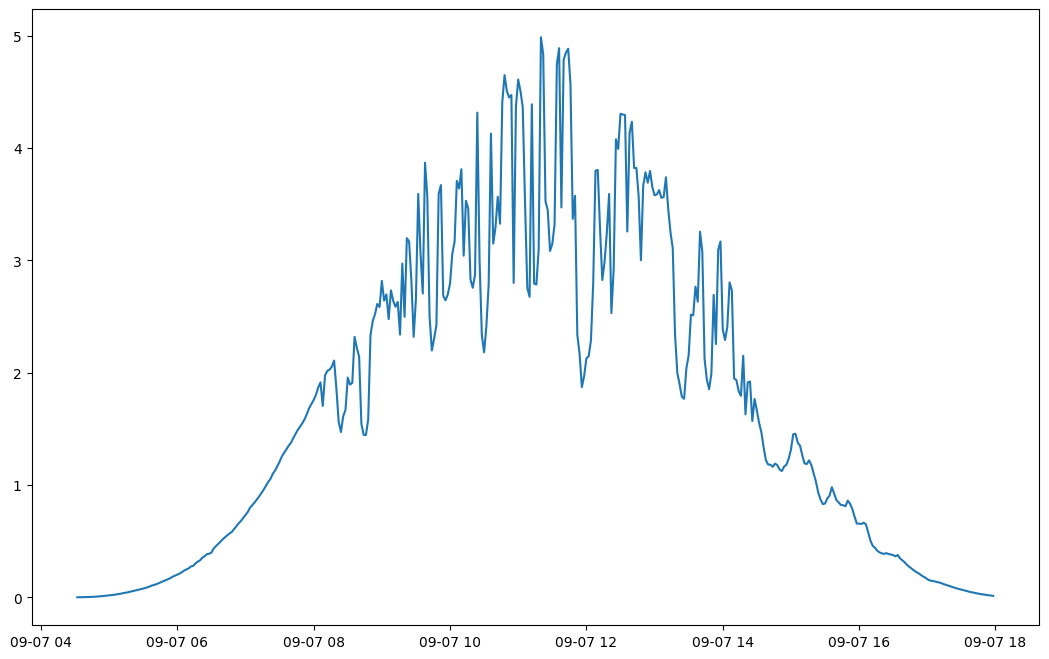

In [41]:
plt.plot(UVI_gefiltert)